In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import cv2

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
transformer = transforms.Compose([
    transforms.Lambda(lambda x: process_face(x) if x is not None else None),
    transforms.ToPILImage(),  
    transforms.ToTensor(),
    transforms.Resize((224, 224),antialias=True),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def process_face(img):
    img = np.array(img)
    faces = has_face_in_tensor(img)
    if faces is not None and len(faces) > 0:
        x, y, w, h = faces[0] 
        face_img = img[y:y + h, x:x + w]
        return face_img
    else:
        return img


def has_face_in_tensor(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    faces = face_cascade.detectMultiScale(img, 1.1, 5) 
    return faces

In [3]:
data_dir = r'C:\Users\lecon\OneDrive\Máy tính\Face Regconition\archive\Celebrity Faces Dataset'
classes = os.listdir(data_dir)

stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=32
channels = 3

dataset = ImageFolder(data_dir, transform=transformer)


In [4]:
classes

['Angelina Jolie',
 'Brad Pitt',
 'Denzel Washington',
 'Hugh Jackman',
 'Jennifer Lawrence',
 'Johnny Depp',
 'Kate Winslet',
 'Leonardo DiCaprio',
 'Megan Fox',
 'Natalie Portman',
 'Nhat Anh',
 'Nicole Kidman',
 'Robert Downey Jr',
 'Sandra Bullock',
 'Scarlett Johansson',
 'Tom Cruise',
 'Tom Hanks',
 'Will Smith']

In [5]:
def denormal(image):
    image = image.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def denormalize(x, mean=stats[0], std=stats[1]):
    ten = x.clone().permute(1, 2, 3, 0)
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2)

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


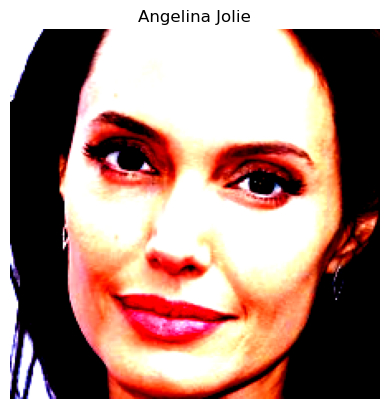

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


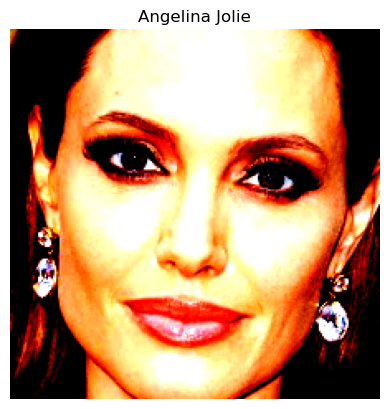

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


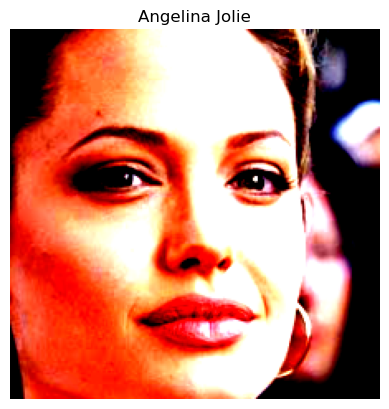

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


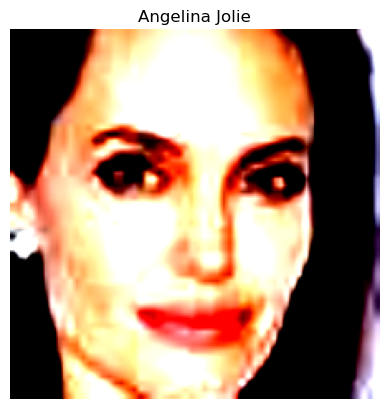

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


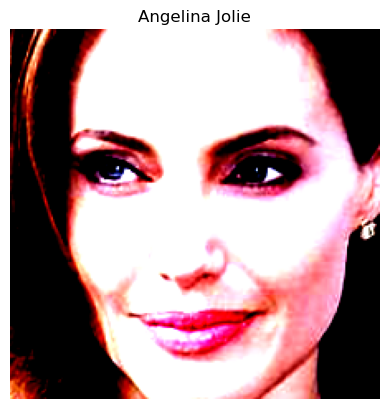

In [6]:

for idx in range(5):
    print(idx)
    img, lbl = dataset[idx]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(dataset.classes[lbl])
    plt.axis('off')
    plt.show()

In [7]:
torch.manual_seed(42)

num_val = int(len(dataset) * 0.1)

dataset, val_ds = random_split(dataset, [len(dataset) - num_val, num_val])

In [8]:
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=0)

### Define network structure

In [9]:
import torch
import torch.nn as nn
from torchsummary import summary
from tqdm.notebook import tqdm
from facenet_pytorch import InceptionResnetV1

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(classes)
).to(device)

In [12]:
learning_rate = 0.00002
n_epochs = 20

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(resnet.parameters(), lr=learning_rate)

### Define training model functions

In [14]:
def train(epoch, n_epochs, model, dl, loss_func, device, optimizer, ds=dataset):
    model.train(True)
    torch.set_grad_enabled(True)
    
    epoch_loss = 0.0
    epochs_acc = 0
    
    tq_batch = tqdm(dl, total=len(dl))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outs = model(images)
        _, preds = torch.max(outs, 1)
        
        loss = loss_func(outs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        
        tq_batch.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
        tq_batch.set_postfix_str('loss = {:.4f}'.format(loss.item()))

            
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

def evaluate(model, dl, loss_func, device, ds=val_ds):

    model.train(False)

    epoch_loss = 0
    epochs_acc = 0
    tq_batch = tqdm(dl, total=len(dl), leave=False)
    for images, labels in tq_batch:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        tq_batch.set_description(f'Evaluate Model')
        
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

def fit(n_epochs, model, train_dataloader, valid_dataloader, loss_func, device, optimizer):
    
    history = []
    val_loss_ref = float('inf')
    patient = 5
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        loss, acc = train(epoch, n_epochs, model, train_dataloader, loss_func, device, optimizer)
        
        torch.cuda.empty_cache()
        val_loss, val_acc = evaluate(model, valid_dataloader, loss_func, device)
        
        history.append({'loss': loss, 'acc': acc, 'val_loss': val_loss, 'val_acc': val_acc})

        statement = "[loss]={:.4f} - [acc]={:.4f} - \[val_loss]={:.4f} - [val_acc]={:.4f}".format(loss, acc, val_loss, val_acc,)
        print(statement)
        # Checkpoint
        if val_loss < val_loss_ref:
            patient = 5
            val_loss_ref = val_loss
            model_path = './Face_Recognition_checkpoint.pth'
            torch.save(model.state_dict(), model_path)
            print(f"[INFO] Saving model dict, Epoch={epoch + 1}")
        else:
            if patient == 0: 
                break
            print(f"[INFO] {patient} lives left!")
            patient -= 1
            
    return history

In [15]:
res = fit(n_epochs, resnet, dl, val_dl, criterion, device, optimizer)
print('Done')

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=1.7973 - [acc]=0.5968 - \[val_loss]=0.9505 - [val_acc]=0.8836
[INFO] Saving model dict, Epoch=1


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.7146 - [acc]=0.8976 - \[val_loss]=0.5497 - [val_acc]=0.9048
[INFO] Saving model dict, Epoch=2


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.4115 - [acc]=0.9421 - \[val_loss]=0.4113 - [val_acc]=0.9312
[INFO] Saving model dict, Epoch=3


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.2798 - [acc]=0.9608 - \[val_loss]=0.4576 - [val_acc]=0.9101
[INFO] 5 lives left!


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.1885 - [acc]=0.9760 - \[val_loss]=0.3823 - [val_acc]=0.9153
[INFO] Saving model dict, Epoch=5


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.1146 - [acc]=0.9941 - \[val_loss]=0.3622 - [val_acc]=0.9206
[INFO] Saving model dict, Epoch=6


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0989 - [acc]=0.9901 - \[val_loss]=0.3602 - [val_acc]=0.9153
[INFO] Saving model dict, Epoch=7


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0746 - [acc]=0.9930 - \[val_loss]=0.3237 - [val_acc]=0.9365
[INFO] Saving model dict, Epoch=8


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0617 - [acc]=0.9947 - \[val_loss]=0.3767 - [val_acc]=0.9206
[INFO] 5 lives left!


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0432 - [acc]=0.9988 - \[val_loss]=0.3816 - [val_acc]=0.9153
[INFO] 4 lives left!


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0368 - [acc]=0.9977 - \[val_loss]=0.3224 - [val_acc]=0.9365
[INFO] Saving model dict, Epoch=11


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0300 - [acc]=0.9977 - \[val_loss]=0.3419 - [val_acc]=0.9206
[INFO] 5 lives left!


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0220 - [acc]=1.0000 - \[val_loss]=0.3450 - [val_acc]=0.9259
[INFO] 4 lives left!


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0200 - [acc]=0.9994 - \[val_loss]=0.3347 - [val_acc]=0.9312
[INFO] 3 lives left!


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0191 - [acc]=0.9994 - \[val_loss]=0.3486 - [val_acc]=0.9206
[INFO] 2 lives left!


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0176 - [acc]=0.9994 - \[val_loss]=0.3463 - [val_acc]=0.9206
[INFO] 1 lives left!


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[loss]=0.0227 - [acc]=0.9977 - \[val_loss]=0.3909 - [val_acc]=0.9048
Done
